# Madrid quality air forecast: Part I - Designing model and forecasting

The mail goal of this notebook is to predict the PM2.5 values for next 24 hours, based on data from latest 24 hours from all stations.
Data used comes from previous notebook where it was downloaded from https://datos.madrid.es/ and preprocessed.

## Import Python packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

## Loading data

In [2]:

# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df_main = pd.read_csv('./data/PM_data_preprocessed.csv', sep=';')


In [3]:
# adding datetime column
df_main['DateTime']=pd.to_datetime(df_main[['Year', 'Month', 'Day', 'Hour']])
df_main.set_index('DateTime',inplace=True)

In [4]:
df_main.head()

,Province,City,Station,Year,Month,Day,Hour,PM25,PM10,Latitude,Longitude,day_of_week
DateTime,,,,,,,,,,,,
2023-01-01 01:00:00,28,79,8,2023,1,1,1,20.0,36.0,40.421564,-3.682283,6
2023-01-01 02:00:00,28,79,8,2023,1,1,2,35.0,51.0,40.421564,-3.682283,6
2023-01-01 03:00:00,28,79,8,2023,1,1,3,35.0,51.0,40.421564,-3.682283,6
2023-01-01 04:00:00,28,79,8,2023,1,1,4,22.0,34.0,40.421564,-3.682283,6
2023-01-01 05:00:00,28,79,8,2023,1,1,5,18.0,28.0,40.421564,-3.682283,6


## Checking data

In [44]:
df_main.describe()

,Province,City,Station,Year,Month,Day,Hour,PM25,PM10,Latitude,Longitude,day_of_week
count,34752.0,34752.0,34752.000000,34752.0,34752.000000,34752.000000,34752.000000,34752.000000,34752.000000,34752.000000,34752.000000,34752.000000
mean,28.0,79.0,41.000000,2023.0,3.508287,15.602210,12.500000,8.562701,17.003752,40.433659,-3.697746,2.988720
std,0.0,0.0,15.945448,0.0,1.709985,8.735448,6.922286,7.171937,12.565382,0.033251,0.024672,1.999709
min,28.0,79.0,8.000000,2023.0,1.000000,1.000000,1.000000,-1.000000,0.000000,40.385028,-3.747344,0.000000
25%,28.0,79.0,34.500000,2023.0,2.000000,8.000000,6.750000,4.000000,9.000000,40.414044,-3.710032,1.000000
50%,28.0,79.0,47.500000,2023.0,4.000000,16.000000,12.500000,7.000000,14.000000,40.430728,-3.689558,3.000000
75%,28.0,79.0,51.500000,2023.0,5.000000,23.000000,18.250000,11.000000,22.000000,40.450556,-3.685690,5.000000
max,28.0,79.0,57.000000,2023.0,6.000000,31.000000,24.000000,81.000000,141.000000,40.494200,-3.660517,6.000000


<Axes: xlabel='DateTime'>

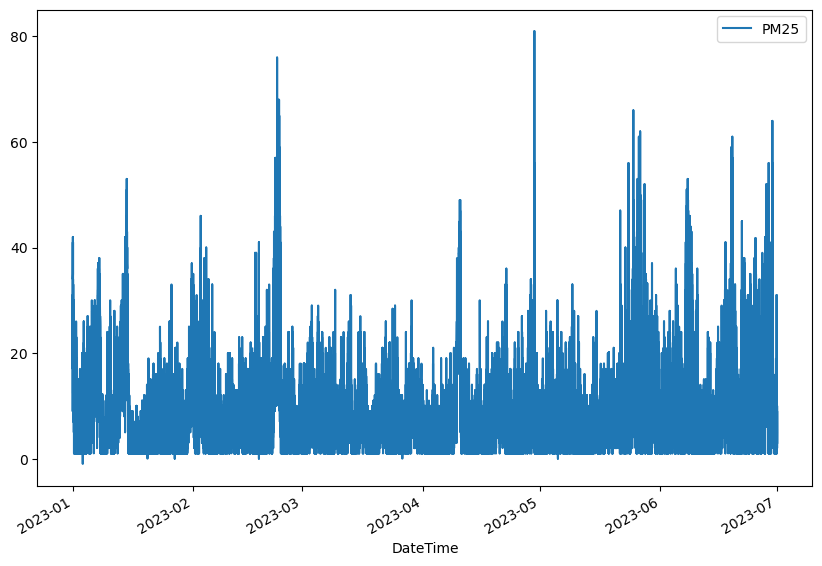

In [6]:
df_main.plot(figsize=(10,7), y='PM25')

### Extracting data
We need to select only the data that will be used by the model. Some columns are not necessary (PM10, lattitude, longitude, etc.)

In [7]:
# Get only the columns needed 

df_extracted = df_main[['Station','Year','Month','Day', 'Hour','day_of_week', 'PM25']]

df_extracted.head()

,Station,Year,Month,Day,Hour,day_of_week,PM25
DateTime,,,,,,,
2023-01-01 01:00:00,8,2023,1,1,1,6,20.0
2023-01-01 02:00:00,8,2023,1,1,2,6,35.0
2023-01-01 03:00:00,8,2023,1,1,3,6,35.0
2023-01-01 04:00:00,8,2023,1,1,4,6,22.0
2023-01-01 05:00:00,8,2023,1,1,5,6,18.0


# Hyper params and global variables

In [8]:
# Save all "global" variables within the G class (G stands for global)
from dataclasses import dataclass

tf.keras.backend.clear_session()
tf.random.set_seed(42)

@dataclass
class G:
    
    SPLIT_TRAINING_PERCENTAGE = 0.8
    SPLIT_TRAINING = int(len(df_extracted) * SPLIT_TRAINING_PERCENTAGE)
    
    FEATURES = 7 # This value is updated when extracted columns from data frame
    TIME_SERIES = ["01/01/2050"] # This value is updated when extracted columns from data frame
    
    WINDOW_SIZE_PAST = 24 # Number of past time steps based on which future observations should be predicted
    WINDOW_SIZE_FUTURE = 24 # Number of future time steps which are to be predicted.
    SHIFT = 1 # By how many positions the window slides to create a new window of observations.
    
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000 # DON'T SHUFFLE IN TIME SERIES!

# Preprocess data

### Extracting time series

In [9]:

time_series = df_extracted.index.values # #returns numpy array -> datetime is an index and cannot be extacted as this: df_extracted["datetime"]
TIME_SERIES = time_series
print(f'time_series length = {len(time_series)} sample: {time_series[:3]}')

print("\n")

G.FEATURES = len(df_extracted.columns)
print(f'Number of features = {G.FEATURES}')


time_series length = 34752 sample: ['2023-01-01T01:00:00.000000000' '2023-01-01T02:00:00.000000000'
 '2023-01-01T03:00:00.000000000']


Number of features = 7


In [46]:
# double checking for null values
NA = pd.DataFrame(data=[df_extracted.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
           for i in (df_extracted.isna().sum()/df_extracted.shape[0]*100).tolist()]], 
           columns=df_extracted.columns, index=['NA Count', 'NA Percent']).transpose()

NA.style.background_gradient(cmap="Pastel1_r", subset=['NA Count'])


,NA Count,NA Percent
Station,0,0.00%
Year,0,0.00%
Month,0,0.00%
Day,0,0.00%
Hour,0,0.00%
day_of_week,0,0.00%
PM25,0,0.00%


### Normalization


In [11]:
# This function normalizes the dataset using min max scaling.
def normalize_series(data):
    min = data.min(axis=0)
    max = data.max(axis=0)
    data = data - min
    data = data / max
    return data

# Normalizes the data
data = df_extracted.values #returns numpy array -> Dataframe index is not included (datetime)
#data = normalize_series(data) # finally used MinMaxScaler instead normalize_series() function

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

### Split data

In [12]:
# Split training/validation
x_train = data[:G.SPLIT_TRAINING]
x_valid = data[G.SPLIT_TRAINING:]

time_train = TIME_SERIES[:G.SPLIT_TRAINING]
time_valid = TIME_SERIES[G.SPLIT_TRAINING:]

print(f'Shape x_train: {x_train.shape}, Shape x_valid: {x_valid.shape} ')
print('\n')
print(f'Shape x_valid: {x_valid.shape}, Shape x_valid: {x_valid.shape} ')
print('\n')
print(f'Shape time_train: {time_train.shape}, Shape time_valid: {time_valid.shape} ')

Shape x_train: (27801, 7), Shape x_valid: (6951, 7) 


Shape x_valid: (6951, 7), Shape x_valid: (6951, 7) 


Shape time_train: (27801,), Shape time_valid: (6951,) 


### Windowed data

In [13]:

# window_size = Number of past time steps based on which future observations should be predicted
# horizon = Number of future time steps which are to be predicted.
# shift = By how many positions the window slides to create a new window of observations.
def windowed_dataset(series, batch_size, window_size=24, horizon=24, shift=1):
    # 1- Create a Dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # 2- Window the data but only take those with the specified size (window contains past and future data)
    dataset = dataset.window(size=window_size + horizon, shift=shift, drop_remainder=True)    
           
    # 3- Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size + horizon))
       
    # 4- Create tuples with features (first elements of the window = window_size) and labels (last elements = horizon)
    dataset = dataset.map(lambda w: (w[:window_size], w[window_size:]))
       
    return dataset.batch(batch_size).prefetch(1)

In [14]:
# Code to create windowed train and validation datasets.
train_set = windowed_dataset(series=x_train, batch_size=G.BATCH_SIZE,
                             window_size=G.WINDOW_SIZE_PAST, horizon=G.WINDOW_SIZE_FUTURE,
                             shift=G.SHIFT)
valid_set = windowed_dataset(series=x_valid, batch_size=G.BATCH_SIZE,
                             window_size=G.WINDOW_SIZE_PAST, horizon=G.WINDOW_SIZE_FUTURE,
                             shift=G.SHIFT)

Metal device set to: Apple M2 Pro


2023-10-09 19:20:31.423341: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-09 19:20:31.423734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model

In [15]:
def create_model():

    tf.random.set_seed(51)
    
    model = tf.keras.models.Sequential([

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, return_sequences=True), 
                                                           input_shape=(G.WINDOW_SIZE_PAST, G.FEATURES)),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True)),

        tf.keras.layers.Dense(14,  activation='relu'),
        tf.keras.layers.Dense(G.FEATURES)
    ])

    return model

## Tune the Learning Rate

In [16]:
def adjust_learning_rate():
    
    model = create_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    # Disable History
    history = model.fit(train_set, validation_data=valid_set, epochs=50, callbacks=[lr_schedule])
    return history

In [17]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/50


2023-10-09 19:20:47.621128: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-09 19:20:48.690736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:20:48.985422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:20:48.994236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:20:49.113613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:20:49.122545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:20:49.310862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

      1/Unknown - 2s 2s/step - loss: 0.0319 - mae: 0.1462

2023-10-09 19:20:49.523522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:20:49.538132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    868/Unknown - 34s 37ms/step - loss: 0.0988 - mae: 0.3556

2023-10-09 19:21:22.322518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:21:22.430678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:21:22.436739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:21:22.533488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:21:22.539709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


868/868 [==============================] - 39s 43ms/step - loss: 0.0988 - mae: 0.3556 - val_loss: 0.1091 - val_mae: 0.3940 - lr: 1.0000e-05
Epoch 2/50
868/868 [==============================] - 36s 41ms/step - loss: 0.0735 - mae: 0.3119 - val_loss: 0.0890 - val_mae: 0.3470 - lr: 1.1220e-05
Epoch 3/50
868/868 [==============================] - 36s 42ms/step - loss: 0.0559 - mae: 0.2609 - val_loss: 0.0697 - val_mae: 0.2959 - lr: 1.2589e-05
Epoch 4/50
868/868 [==============================] - 36s 42ms/step - loss: 0.0428 - mae: 0.2176 - val_loss: 0.0525 - val_mae: 0.2507 - lr: 1.4125e-05
Epoch 5/50
868/868 [==============================] - 36s 41ms/step - loss: 0.0321 - mae: 0.1804 - val_loss: 0.0378 - val_mae: 0.2067 - lr: 1.5849e-05
Epoch 6/50
868/868 [==============================] - 36s 42ms/step - loss: 0.0240 - mae: 0.1487 - val_loss: 0.0267 - val_mae: 0.1673 - lr: 1.7783e-05
Epoch 7/50
868/868 [==============================] - 36s 41ms/step - loss: 0.0188 - mae: 0.1278 - val_lo

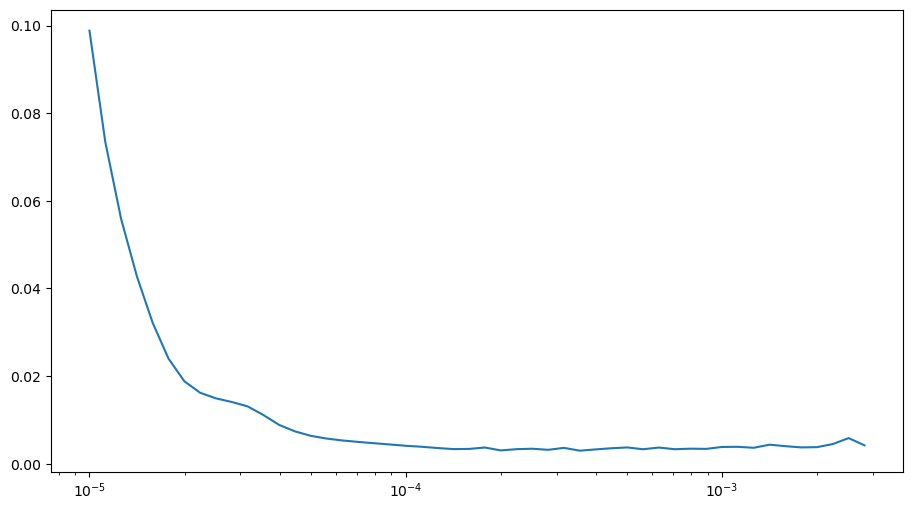

In [18]:
plt.figure(figsize=(11, 6))
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])

It seems that optimal learning rate is between 1e-4 (0.0001) and 1e-6 (0.001)

## Train the Model

Once picked a learning rate, we can rebuild the model and start training.

In [19]:
keras.backend.clear_session()

model = create_model()

initial_learning_rate = 0.0001

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 192)          79872     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 96)           92544     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24, 14)            1358      
                                                                 
 dense_1 (Dense)             (None, 24, 7)             105       
                                                                 
Total params: 173,879
Trainable params: 173,879
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

class stop_mae(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    mae = logs.get('val_mae')
    if(mae < 0.0010):
        # Stop if threshold is met
        print("\nRequired val MAE is met so cancelling training!")
        self.model.stop_training = True

# Instantiate the class
stop_mae_callback = stop_mae()

callbacks = [
    stop_mae_callback,
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6, patience=10, mode='min', verbose=1, factor=0.1),
    ModelCheckpoint(monitor='val_loss', filepath='./model/air_quality.h5', save_best_only=True, verbose=1)
]



history = model.fit(train_set, validation_data=valid_set, epochs=200, callbacks=[callbacks])

Epoch 1/200


2023-10-09 19:52:03.978738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:04.277751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:04.286446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:04.388174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:04.397049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:04.556558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:04.557872: I tensorflow/core/grappler/optimizers/cust

      1/Unknown - 2s 2s/step - loss: 0.0319 - mae: 0.1462

2023-10-09 19:52:04.760083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    868/Unknown - 35s 38ms/step - loss: 0.0445 - mae: 0.2338

2023-10-09 19:52:37.791502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:37.908726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:37.914847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:38.022373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 19:52:38.029084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.02947, saving model to ./model/aire.h5
868/868 [==============================] - 40s 43ms/step - loss: 0.0445 - mae: 0.2338 - val_loss: 0.0295 - val_mae: 0.1821 - lr: 1.0000e-04
Epoch 2/200
867/868 [============================>.] - ETA: 0s - loss: 0.0189 - mae: 0.1371
Epoch 2: val_loss improved from 0.02947 to 0.01700, saving model to ./model/aire.h5
868/868 [==============================] - 36s 41ms/step - loss: 0.0189 - mae: 0.1371 - val_loss: 0.0170 - val_mae: 0.1307 - lr: 1.0000e-04
Epoch 3/200
867/868 [============================>.] - ETA: 0s - loss: 0.0131 - mae: 0.1059
Epoch 3: val_loss improved from 0.01700 to 0.01225, saving model to ./model/aire.h5
868/868 [==============================] - 36s 42ms/step - loss: 0.0131 - mae: 0.1059 - val_loss: 0.0122 - val_mae: 0.1070 - lr: 1.0000e-04
Epoch 4/200
867/868 [============================>.] - ETA: 0s - loss: 0.0084 - mae: 0.0794
Epoch 4: val_loss improved from 0.01225 to 0.00922, sav

867/868 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0307
Epoch 28: val_loss improved from 0.00257 to 0.00200, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 0.0017 - mae: 0.0307 - val_loss: 0.0020 - val_mae: 0.0332 - lr: 1.0000e-04
Epoch 29/200
867/868 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0308
Epoch 29: val_loss improved from 0.00200 to 0.00189, saving model to ./model/aire.h5
868/868 [==============================] - 36s 41ms/step - loss: 0.0017 - mae: 0.0308 - val_loss: 0.0019 - val_mae: 0.0374 - lr: 1.0000e-04
Epoch 30/200
867/868 [============================>.] - ETA: 0s - loss: 0.0018 - mae: 0.0311
Epoch 30: val_loss did not improve from 0.00189
868/868 [==============================] - 35s 41ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 0.0024 - val_mae: 0.0428 - lr: 1.0000e-04
Epoch 31/200
867/868 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0288
Epo


Epoch 54: val_loss improved from 0.00103 to 0.00102, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 8.6699e-04 - mae: 0.0201 - val_loss: 0.0010 - val_mae: 0.0204 - lr: 1.0000e-05
Epoch 55/200
867/868 [============================>.] - ETA: 0s - loss: 8.7794e-04 - mae: 0.0209
Epoch 55: val_loss improved from 0.00102 to 0.00099, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 8.7789e-04 - mae: 0.0209 - val_loss: 9.9284e-04 - val_mae: 0.0208 - lr: 1.0000e-06
Epoch 56/200
867/868 [============================>.] - ETA: 0s - loss: 8.7494e-04 - mae: 0.0208
Epoch 56: val_loss improved from 0.00099 to 0.00098, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 8.7488e-04 - mae: 0.0208 - val_loss: 9.8429e-04 - val_mae: 0.0209 - lr: 1.0000e-06
Epoch 57/200
867/868 [============================>.] - ETA: 0s - loss: 8.6933e-04 - mae: 0.0206
Epoch 57: val

867/868 [============================>.] - ETA: 0s - loss: 8.3177e-04 - mae: 0.0199
Epoch 79: val_loss improved from 0.00093 to 0.00093, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 8.3172e-04 - mae: 0.0199 - val_loss: 9.3042e-04 - val_mae: 0.0204 - lr: 1.0000e-06
Epoch 80/200
867/868 [============================>.] - ETA: 0s - loss: 8.3077e-04 - mae: 0.0199
Epoch 80: val_loss improved from 0.00093 to 0.00093, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 8.3072e-04 - mae: 0.0199 - val_loss: 9.2894e-04 - val_mae: 0.0203 - lr: 1.0000e-06
Epoch 81/200
867/868 [============================>.] - ETA: 0s - loss: 8.2979e-04 - mae: 0.0198
Epoch 81: val_loss improved from 0.00093 to 0.00093, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 8.2974e-04 - mae: 0.0198 - val_loss: 9.2751e-04 - val_mae: 0.0203 - lr: 1.0000e-06
Epoch 82/200
868/868 [=

Epoch 104/200
867/868 [============================>.] - ETA: 0s - loss: 8.0963e-04 - mae: 0.0195
Epoch 104: val_loss improved from 0.00090 to 0.00090, saving model to ./model/aire.h5
868/868 [==============================] - 36s 42ms/step - loss: 8.0959e-04 - mae: 0.0195 - val_loss: 9.0216e-04 - val_mae: 0.0199 - lr: 1.0000e-06
Epoch 105/200
867/868 [============================>.] - ETA: 0s - loss: 8.0882e-04 - mae: 0.0195
Epoch 105: val_loss improved from 0.00090 to 0.00090, saving model to ./model/aire.h5
868/868 [==============================] - 36s 42ms/step - loss: 8.0878e-04 - mae: 0.0195 - val_loss: 9.0126e-04 - val_mae: 0.0199 - lr: 1.0000e-06
Epoch 106/200
867/868 [============================>.] - ETA: 0s - loss: 8.0802e-04 - mae: 0.0195
Epoch 106: val_loss improved from 0.00090 to 0.00090, saving model to ./model/aire.h5
868/868 [==============================] - 36s 42ms/step - loss: 8.0798e-04 - mae: 0.0195 - val_loss: 9.0037e-04 - val_mae: 0.0199 - lr: 1.0000e-06
Epoc

Epoch 129/200
867/868 [============================>.] - ETA: 0s - loss: 7.9048e-04 - mae: 0.0192
Epoch 129: val_loss improved from 0.00088 to 0.00088, saving model to ./model/aire.h5
868/868 [==============================] - 37s 42ms/step - loss: 7.9044e-04 - mae: 0.0193 - val_loss: 8.8193e-04 - val_mae: 0.0196 - lr: 1.0000e-06
Epoch 130/200
867/868 [============================>.] - ETA: 0s - loss: 7.8975e-04 - mae: 0.0192
Epoch 130: val_loss improved from 0.00088 to 0.00088, saving model to ./model/aire.h5
868/868 [==============================] - 36s 42ms/step - loss: 7.8971e-04 - mae: 0.0192 - val_loss: 8.8118e-04 - val_mae: 0.0196 - lr: 1.0000e-06
Epoch 131/200
867/868 [============================>.] - ETA: 0s - loss: 7.8902e-04 - mae: 0.0192
Epoch 131: val_loss improved from 0.00088 to 0.00088, saving model to ./model/aire.h5
868/868 [==============================] - 36s 42ms/step - loss: 7.8898e-04 - mae: 0.0192 - val_loss: 8.8044e-04 - val_mae: 0.0196 - lr: 1.0000e-06
Epoc

Epoch 154/200
867/868 [============================>.] - ETA: 0s - loss: 7.7282e-04 - mae: 0.0190
Epoch 154: val_loss improved from 0.00086 to 0.00086, saving model to ./model/aire.h5
868/868 [==============================] - 36s 41ms/step - loss: 7.7278e-04 - mae: 0.0190 - val_loss: 8.6412e-04 - val_mae: 0.0194 - lr: 1.0000e-06
Epoch 155/200
867/868 [============================>.] - ETA: 0s - loss: 7.7213e-04 - mae: 0.0190
Epoch 155: val_loss improved from 0.00086 to 0.00086, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 7.7210e-04 - mae: 0.0190 - val_loss: 8.6344e-04 - val_mae: 0.0194 - lr: 1.0000e-06
Epoch 156/200
867/868 [============================>.] - ETA: 0s - loss: 7.7145e-04 - mae: 0.0190
Epoch 156: val_loss improved from 0.00086 to 0.00086, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 7.7142e-04 - mae: 0.0190 - val_loss: 8.6276e-04 - val_mae: 0.0194 - lr: 1.0000e-06
Epoc

Epoch 179/200
867/868 [============================>.] - ETA: 0s - loss: 7.5612e-04 - mae: 0.0188
Epoch 179: val_loss improved from 0.00085 to 0.00085, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 7.5610e-04 - mae: 0.0188 - val_loss: 8.4723e-04 - val_mae: 0.0192 - lr: 1.0000e-06
Epoch 180/200
867/868 [============================>.] - ETA: 0s - loss: 7.5547e-04 - mae: 0.0188
Epoch 180: val_loss improved from 0.00085 to 0.00085, saving model to ./model/aire.h5
868/868 [==============================] - 35s 41ms/step - loss: 7.5545e-04 - mae: 0.0188 - val_loss: 8.4656e-04 - val_mae: 0.0192 - lr: 1.0000e-06
Epoch 181/200
867/868 [============================>.] - ETA: 0s - loss: 7.5482e-04 - mae: 0.0188
Epoch 181: val_loss improved from 0.00085 to 0.00085, saving model to ./model/aire.h5
868/868 [==============================] - 35s 40ms/step - loss: 7.5480e-04 - mae: 0.0188 - val_loss: 8.4589e-04 - val_mae: 0.0192 - lr: 1.0000e-06
Epoc

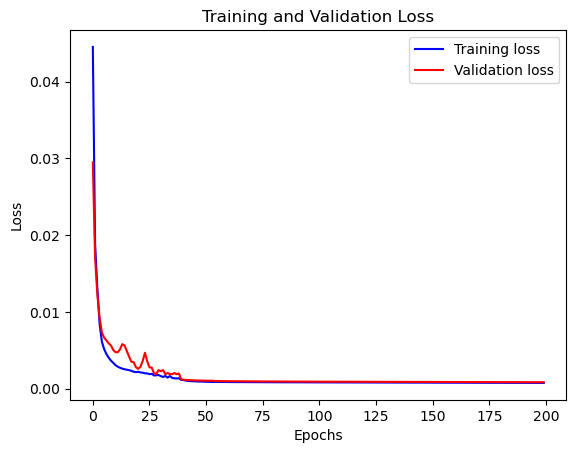

In [21]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

# Model Prediction

In [22]:
def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def mae(y_true, y_pred):
    return np.mean(abs(y_true.ravel() - y_pred.ravel()))

In [ ]:
#model = tf.keras.models.load_model('./model/air_quality.h5')

In [23]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, data, G.WINDOW_SIZE_PAST, G.BATCH_SIZE)


2023-10-09 21:53:22.024365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 21:53:22.124208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 21:53:22.131117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 21:53:22.249229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-09 21:53:22.255793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [47]:

rnn_forecast_squeeze = rnn_forecast.squeeze()
print(f'rnn_forecast_squeeze.shape = {rnn_forecast_squeeze.shape}')

rnn_forecast_reshaped = rnn_forecast[:, 0, :] # removing window dimension
print(f'rnn_forecast_reshaped.shape = {rnn_forecast_reshaped.shape}')


# Slice the forecast to get only the predictions for the validation set
rnn_forecast_validation = rnn_forecast_reshaped[G.SPLIT_TRAINING - G.WINDOW_SIZE_PAST:-1]
print(f'rnn_forecast_validation.shape = {rnn_forecast_validation.shape}')


x_valid_n = x_valid[:rnn_forecast.shape[0]]
print(f'x_valid_n shape = {x_valid_n.shape}')

result = np.mean(abs(x_valid_n - rnn_forecast_validation))

print(f'result = {result}')


fv = scaler.inverse_transform(rnn_forecast_validation)
val = scaler.inverse_transform(x_valid_n)

result = np.mean(abs(val[:,-1] - fv[:,-1]))

print(f'result = {result}')

rnn_forecast_squeeze.shape = (34729, 24, 7)
rnn_forecast_reshaped.shape = (34729, 7)
rnn_forecast_validation.shape = (6951, 7)
x_valid_n shape = (6951, 7)
result = 0.02269409065428377
result = 3.395254559020244


## Plotting predictions

In [25]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend()
    plt.grid(False)

In [48]:

inv_forecast = scaler.inverse_transform(rnn_forecast_reshaped)

print(inv_forecast[1:10,:])

inv_data = scaler.inverse_transform(data)


[[9.62994289e+00 2.02298254e+03 1.23653877e+00 3.02174854e+00
  1.19880605e+00 1.35356382e-01 7.80702114e+00]
 [9.67164326e+00 2.02299133e+03 1.22064960e+00 2.80447078e+00
  2.42631578e+00 1.24472961e-01 8.18508148e+00]
 [9.74496269e+00 2.02299927e+03 1.19623363e+00 2.55440831e+00
  3.65731621e+00 1.03631660e-01 8.57102966e+00]
 [1.00617123e+01 2.02300745e+03 1.18883753e+00 2.34925771e+00
  4.79509735e+00 1.06822953e-01 8.88071537e+00]
 [1.04155025e+01 2.02301501e+03 1.18527555e+00 2.20019579e+00
  5.90352297e+00 1.24284044e-01 9.34005356e+00]
 [1.07983742e+01 2.02302197e+03 1.18744504e+00 2.13463092e+00
  6.99168587e+00 1.63921148e-01 1.00233374e+01]
 [1.07764492e+01 2.02302295e+03 1.17922473e+00 2.15517473e+00
  7.86431789e+00 2.59332001e-01 1.01637621e+01]
 [1.07542877e+01 2.02302234e+03 1.16936576e+00 2.20549822e+00
  8.70098305e+00 3.88425946e-01 1.02786074e+01]
 [1.07391100e+01 2.02301953e+03 1.16016161e+00 2.31704974e+00
  9.53382587e+00 5.56347132e-01 1.04377403e+01]]


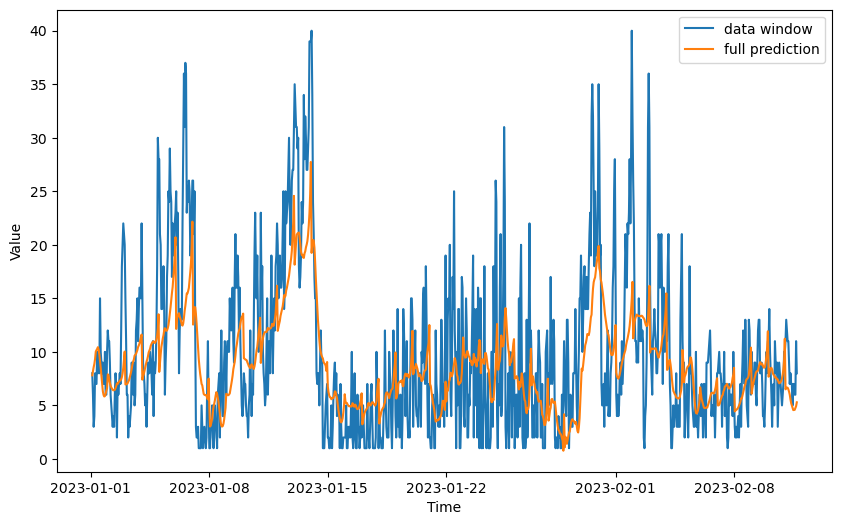

In [49]:
# Plotting initial data vs predictions

start_row =1
num_rows= start_row + 1000 # plot 1000 rows predicted
plt.figure(figsize=(10, 6))
plot_series(TIME_SERIES[start_row:num_rows], inv_data[start_row + G.WINDOW_SIZE_PAST: G.WINDOW_SIZE_PAST+num_rows,-1:], label = "data window")
plot_series(TIME_SERIES[start_row:num_rows], inv_forecast[start_row:num_rows,-1:], label="full prediction")
                                        

In [28]:
inv_x_valid_n = scaler.inverse_transform(x_valid_n)
inv_rnn_forecast_validation = scaler.inverse_transform(rnn_forecast_validation)


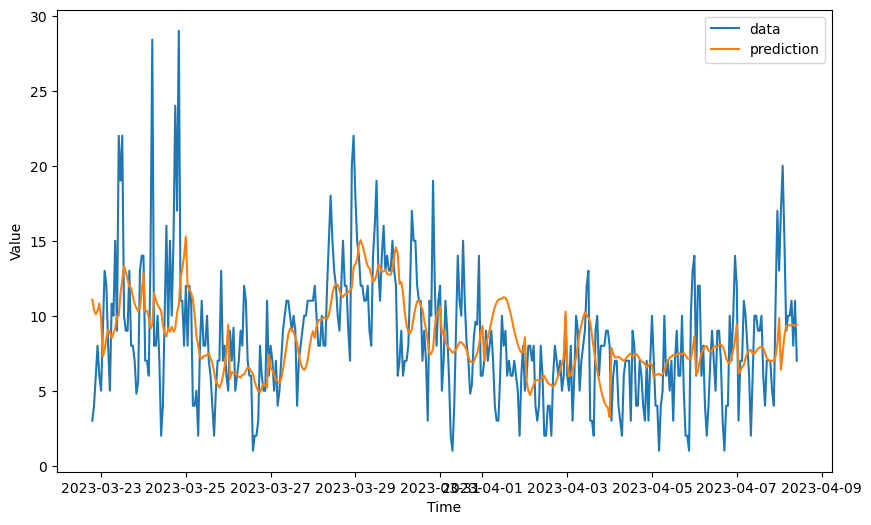

In [42]:
# Plot the forecast for validation data
start_row =201
num_rows = start_row + 400

plt.figure(figsize=(10, 6))

plot_series(time_valid[start_row:num_rows], inv_x_valid_n[start_row:num_rows,-1:], label="data")
plot_series(time_valid[start_row:num_rows], inv_rnn_forecast_validation[start_row:num_rows,-1:], label="prediction")


### Exporting forecast to Excel

In [30]:
df_inv_rnn_forecast_validation = pd.DataFrame(inv_rnn_forecast_validation, columns = ['Station','Year','Month','Day', 'Hour','day_of_week', 'PM25'])
df_inv_rnn_forecast_validation_INT = df_inv_rnn_forecast_validation.astype('int')

df_x_valid_n = pd.DataFrame(inv_x_valid_n, columns = ['Station','Year','Month','Day', 'Hour','day_of_week', 'PM25'])


# Write to Multiple Sheets
with pd.ExcelWriter('./data/Temp_Check_data.xlsx') as writer:
    df_x_valid_n.to_excel(writer, sheet_name='Validation data')
    df_inv_rnn_forecast_validation_INT.to_excel(writer, sheet_name='Forecast')


### Done!!